In [1]:
from compute import Var, eqvar, ureg, get_unit, buildidpvars, coupled_run, Evaluable, args_in_order, fill_args, unit_conversion_factors, evaluable_with_unit
from inputresolver import reassigneq, eqvars, eqsonly, default_out, mdf_order, default_in, idx_eqlist
from inputresolver import getallvars, invert_edges, resolve, reassign, flatten_order
from representations import bipartite_repr, drawbipartite, digraph_repr, draw, draw_dsm
from compute_utils import get_outputs, check_eqs, print_out
from partitioner import default_out_condensation, merge
from pprint import pprint
import networkx as nx
import sympy as sp
from sympy.utilities.lambdify import implemented_function
import numpy as np
from scipy import interpolate
import openmdao.api as om
import gpkit as gp
import cvxpy as cp
import matplotlib.patches as patches

In [2]:
from functools import reduce
from itertools import chain
from collections import OrderedDict
import matplotlib.pyplot as plt

In [3]:
μ = Var('mu', 3.986005e14, 'm^3/s^2', never_output=True)
R = Var('R', 6378, 'km', never_output=True)
Q = Var('Q', 1367, 'W/m^2', never_output=True)
#EN = Var('EN', 10, never_output=True) #
D_r = Var('D_r', 5.3, 'm', never_output=True)
L = Var('L', 9.77, never_output=True)
k = Var('k', 1.38064852e-23, 'J/K', never_output=True)
T_s = Var('T_s', 135, 'K', never_output=True)
B = Var('B', 8, 'bit', never_output=True)
N = Var('N', 2e3, '', never_output=True)
eta = Var('eta', 0.55, never_output=True)
l_v = Var('l_v', 500, 'nm', never_output=True)
f = Var('f', 2.2, 'GHz', never_output=True)
c = Var('c', 2.99e8, 'm/s', never_output=True) #
rho_T = Var('rho_T', 500e3, 'kg*m', never_output=True)
rho_P = Var('rho_P', 0.002e-3, 'kg/J', never_output=True)
P_l = Var('P_l', 12, 'W', never_output=True)
m_c = Var('m_c', 0.2, 'kg', never_output=True)
C_D = Var('C_D', 2.2, never_output=True)
G = Var('G', 9.81, 'm/s^2', never_output=True)
I_sp = Var('Isp', 70, 's', never_output=True)
w_W = Var('w_W', 1000, 'rad/s', never_output=True)
c_W = Var('c_W', 1, never_output=True)
rho_M = Var('rho_M', 11.4, never_output=True)
rho_P2 = Var('rho_P2', 9/0.1, never_output=True)
M_B = Var('M_B', 7.96e15, never_output=True)
kp = Var('kp', 0.0002, never_output=True)

In [7]:
h = Var('h', 400, 'km') #
a, eq0 = eqvar('a', h + R, 'km')
T, eq1 = eqvar('T', 2*np.pi*(a**3/μ)**0.5, 'min')
g, eq2 = eqvar('g', 1/np.pi*sp.acos(R/a), '')
d, eq3 = eqvar('d', g+0.5)
r, eq4 = eqvar('r', (h**2+2*R*h)**0.5)

In [8]:
eta_A = Var('eta_A', 0.3, never_output=True)
rho_A = Var('rho_A', 10, 'kg/m^2', never_output=True) #
#ρ_A, η_A = ρ_Ai[solar], η_Ai[solar]
A = Var('A', 0.05, unit='m^2')
m_A, eq5 = eqvar('m_A', rho_A*A)
P_c, eq6 = eqvar('P_c', d*A*Q*eta_A, 'W')
P_T, eq7 = eqvar('P_T', P_c-P_l) #hack
E_b, eq8 = eqvar('E_b', P_c*T/d)
rho_b = Var('rho_b', 0.002, 'kg/kJ', never_output=True)
m_b, eq9 = eqvar('m_b', rho_b*E_b, 'kg')
#E_b, m_b = E_bi[bat], m_bi[bat]

In [9]:
X_r = Var('X_r', 5, 'm')
D_p, eq10 = eqvar('D_p', 1.22*l_v*h/X_r)
D, eq11 = eqvar('D', 2*np.pi*R*B*N/X_r, 'MB')
rho_p = Var('rho_p', 2, 'kg/m^1.5', never_output=True) 
#D_p, m_p = D_pi[payload], m_pi[payload]
m_p, eq12 = eqvar('m_p', rho_p*D_p**1.5, 'kg')

In [10]:
dBtoLinear = lambda db: 10**(db/10)

In [11]:
b, eq13 = eqvar('b', D/T, 'MB/s')
λ_c, eq14 = eqvar('l_c', c/f, 'cm')
G_T = Var('G_T', dBtoLinear(16.5), '', never_output=True)
D_T, eq15 = eqvar('D_T', λ_c*(G_T/eta)**0.5/np.pi, 'm')
rho_T = Var('rho_T', 0.2, 'kg/m^1.5', never_output=True)
m_T, eq16b = eqvar('m_T', rho_T*D_T**1.5, 'kg')
#m_T, P_T, G_T = m_Ti[comms], P_Ti[comms], G_Ti[comms]
G_r, eq16 = eqvar('G_r', eta*(np.pi*D_r/λ_c)**2)
EN, eq17 = eqvar('EN', P_T*G_r*G_T/(L*k*T_s*b)*(λ_c/(4*np.pi*r))**2, '')

In [12]:
np.log10(10*9.86335375)

1.9940246094105376

In [13]:
mt = Var('mt', unit='kg')
eta_S = Var('eta_S', 0.2, never_output=True)
m_s, eq18 = eqvar('m_s', eta_S*mt)
eq19 = (mt, m_T+m_p+m_b+m_A+m_s)

In [14]:
h_ρi = np.array([100, 150, 200, 250, 300, 350, 400, 450, 500, 
                 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1250, 1500])*1e3
ρi = np.array([4.79e-07, 1.81e-09, 2.53e-10, 6.24e-11, 1.95e-11, 6.98e-12, 2.72e-12, 
               1.13e-12, 4.89e-13, 2.21e-13, 1.04e-13, 5.15e-14, 2.72e-14, 1.55e-14, 
               9.63e-15, 6.47e-15, 4.66e-15, 3.54e-15, 2.79e-15, 1.11e-15, 5.21e-16])
Hi = np.array([5.9, 25.5, 37.5, 44.8, 50.3, 54.8, 58.2, 61.3, 64.5, 68.7, 74.8, 84.4, 
               99.3, 121, 151, 188, 226, 263, 296, 408, 516])*1e3
ρinterp = interpolate.interp1d(np.log(h_ρi), np.log(ρi))
Hinterp = interpolate.interp1d(np.log(h_ρi), np.log(Hi))
ρ_int = lambda h: ρi[0] if h<=h_ρi[0] else np.exp(ρinterp(np.log(h))) if h <= 1500e3 else 5.21e-16
H_int = lambda h: Hi[0] if h<=h_ρi[0] else np.exp(Hinterp(np.log(h))) if h <= 1500e3 else 516e3

In [15]:
H = implemented_function(sp.Function('H'), H_int)
rho = implemented_function(sp.Function('rho'),  ρ_int)

In [16]:
L_min = Var('L_min', 5, 'yr')
m_pr = Var('m_pr', 0.5, unit='kg')
Hval, eq20 = eqvar('H_val', H(h*1e3), 'm', forceunit=True)
rhoval, eq21 = eqvar('rho_val', rho(h*1e3), 'kg/m**3', forceunit=True)
Ln, eq22 = eqvar('L_n', Hval*mt/(2*np.pi*C_D*A*rhoval*a**2)*T, 'yr')
Lp, eq23 = eqvar('L_p', m_pr*I_sp*G*a/(0.5*C_D*A*rhoval*μ), 'yr')
Lt, eq24 = eqvar('L_t', Ln+Lp, 'yr')

In [17]:
alleqs = [eq0,eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10,eq11,eq12,eq13,eq14,eq15,eq16,eq16b,eq17,eq18,eq19,eq20,eq21,eq22,eq23,eq24]

In [18]:
#alleqs = [eq0,eq1,eq2,eq3,eq4,eq5,eq6, eq7]

In [19]:
eqs = idx_eqlist(alleqs)
eqv = eqvars(eqs)
dout = default_out(eqs)
dins = default_in(eqs, count_never_output=False)
order = mdf_order(eqv, dout)

In [20]:
prob = om.Problem()
model = prob.model
dins = default_in(eqs)
buildidpvars(dins, model)
counter = coupled_run(eqs, order, (), model, model, debug=True)
prob.setup()
prob.set_solver_print(level=0)
prob.set_val('A', 0.05)
prob.set_val('h', 400)
#prob.set_val('m_pr', 0.5)
prob.run_model()

eq14 l_c c/f None
eq16 G_r 9.86960440108936*D_r**2*eta/l_c**2 None
eq15 D_T 0.318309886183791*l_c*(G_T/eta)**0.5 None
eq17 m_T D_T**1.5*rho_T None
eq5 m_A A*rho_A None
eq11 D 6.28318530717959*B*N*R/X_r None
eq22 rho_val rho(1000.0*h) None
eq21 H_val H(1000.0*h) None
eq10 D_p 1.22*h*l_v/X_r None
eq12 m_p D_p**1.5*rho_p None
eq4 r (2*R*h + h**2)**0.5 None
eq0 a R + h None
eq24 L_p 2.0*G*Isp*a*m_pr/(A*C_D*mu*rho_val) None
eq2 g 0.318309886183791*acos(R/a) None
eq3 d g + 0.5 None
eq6 P_c A*Q*d*eta_A None
eq7 P_T P_c - P_l None
eq1 T 6.28318530717959*(a**3/mu)**0.5 None
eq13 b D/T None
eq18 EN 0.00633257397764611*G_T*G_r*P_T*l_c**2/(L*T_s*b*k*r**2) None
eq8 E_b P_c*T/d None
eq9 m_b E_b*rho_b None
eq20 mt m_A + m_T + m_b + m_p + m_s None
eq19 m_s eta_S*mt None
eq23 L_n 0.159154943091895*H_val*T*mt/(A*C_D*a**2*rho_val) None
eq25 L_t L_n + L_p None
l_c [13.59090909]
G_r [8255.00154877]
D_T [0.38986773]
m_T [0.04868621]
m_A [0.5]
D [16029.66235568]
rho_val [2.72e-12]
H_val [58200.]
D_p [0.0488]

In [33]:
model.list_outputs()

54 Explicit Output(s) in 'model'

varname      val               
-----------  ------------------
inp
  eta_A      [0.3]             
  eta_S      [0.2]             
  R          [6378.]           
  T_s        [135.]            
  Q          [1367.]           
  eta        [0.55]            
  m_pr       [0.5]             
  rho_T      [0.2]             
  B          [8.]              
  rho_p      [2.]              
  f          [2.2]             
  L          [9.77]            
  D_r        [5.3]             
  l_v        [500.]            
  rho_A      [10.]             
  A          [0.05]            
  c          [2.99e+08]        
  G          [9.81]            
  P_l        [12.]             
  k          [1.38064852e-23]  
  h          [400.]            
  X_r        [5.]              
  G_T        [44.66835922]     
  Isp        [70.]             
  N          [2000.]           
  mu         [3.986005e+14]    
  C_D        [2.2]             
  rho_b      [0.002]           
gr

[('inp.eta_A', {'val': array([0.3])}),
 ('inp.eta_S', {'val': array([0.2])}),
 ('inp.R', {'val': array([6378.])}),
 ('inp.T_s', {'val': array([135.])}),
 ('inp.Q', {'val': array([1367.])}),
 ('inp.eta', {'val': array([0.55])}),
 ('inp.m_pr', {'val': array([0.5])}),
 ('inp.rho_T', {'val': array([0.2])}),
 ('inp.B', {'val': array([8.])}),
 ('inp.rho_p', {'val': array([2.])}),
 ('inp.f', {'val': array([2.2])}),
 ('inp.L', {'val': array([9.77])}),
 ('inp.D_r', {'val': array([5.3])}),
 ('inp.l_v', {'val': array([500.])}),
 ('inp.rho_A', {'val': array([10.])}),
 ('inp.A', {'val': array([0.05])}),
 ('inp.c', {'val': array([2.99e+08])}),
 ('inp.G', {'val': array([9.81])}),
 ('inp.P_l', {'val': array([12.])}),
 ('inp.k', {'val': array([1.38064852e-23])}),
 ('inp.h', {'val': array([400.])}),
 ('inp.X_r', {'val': array([5.])}),
 ('inp.G_T', {'val': array([44.66835922])}),
 ('inp.Isp', {'val': array([70.])}),
 ('inp.N', {'val': array([2000.])}),
 ('inp.mu', {'val': array([3.986005e+14])}),
 ('inp.

In [21]:
out = get_outputs(eqs, model)

In [29]:
out2 = {str(key):var for key,var in out.items()}

In [30]:
out2["a"]

6778.0

In [32]:
{key:(out2[str(left)], Evaluable.fromsympy(right).evaldict(out2)) for key, (left, right) 
        in eqs.items()}

{0: (6778.0, 6778.0),
 1: (92.55759152545728, 0.17561568237596617),
 2: (0.10990150360973472, 0.10990150360973472),
 3: (0.6099015036097347, 0.6099015036097347),
 4: (2293992.153430347, 2293.9921534303467),
 5: (0.5, 0.5),
 6: (12.50603033151761, 12.50603033151761),
 7: (0.5060303315176107, 0.5060303315176107),
 8: (113873.60485377008, 1897.8934142295016),
 9: (0.22774720970754017, 227.74720970754018),
 10: (0.04880000000000001, 48800.0),
 11: (16029.66235567657, 128237298.84541254),
 12: (0.02156054470554954, 0.02156054470554954),
 13: (2.886430327952035, 173.1858196771221),
 14: (13.59090909090909, 135909090.9090909),
 15: (0.3898677305937878, 38.986773059378784),
 16: (8255.001548774731, 0.8255001548774731),
 17: (0.04868620582342001, 0.04868620582342001),
 18: (9.863353746021069, 789068299681.6855),
 19: (0.19949849005912745, 0.19949849005912745),
 20: (0.9974924502956372, 0.9974924502956372),
 21: (58200.0, 58200.0),
 22: (2.7199999999999953e-12, 2.7199999999999953e-12),
 23: (0.1

In [14]:
# def default_out_condensation(alleqs, eqlist):
#     out = set()
#     remove = set()
#     keep = set()
#     for left, _ in eqlist:
#         out = out.union({left})
#     for _, right in eqlist:
#         remove = remove.union(right.free_symbols)
#     for _, right in set(alleqs)-set(eqlist):
#         keep = keep.union(right.free_symbols)
#     out = out.intersection(keep)
#     out.union(keep-remove)
#     return out

In [15]:
# def merge(alleqs, eqs, eqname):
#     din_s1 = default_in(eqs, eqdictin=False)
#     din_s1 = [elt for elt in din_s1 if not elt.never_output]
#     dout_s1 = default_out2(alleqs, eqs)
#     edges = tuple((elt, eqname) for elt in din_s1)+tuple((eqname, elt) for elt in dout_s1)
#     return edges

In [33]:
alleqs = [eq0,eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10,eq11,eq12,eq13,eq14,eq15,eq16,eq16b,eq17,eq18,eq19,eq20,eq21,eq22,eq23,eq24]
#default_out_condensation(alleqs, [eq0, eq1, eq2, eq3, eq4])

{T, a, d, r}

In [17]:
eqs = idx_eqlist(alleqs)
eqv = eqvars(eqs)
dout = default_out(eqs)
dins = default_in(eqs, count_never_output=False)

In [18]:
dins

{A, X_r, h, m_pr}

In [34]:
eqv_noparams = {elt:{key for key in keys if not key.never_output} for elt,keys in eqv.items()}
DG, edges = digraph_repr(eqv_noparams, dout, intermediary=False)

In [23]:
dout.values()

dict_values([a, T, g, d, r, m_A, P_T, P_T, E_b, m_b, D_p, D, m_p, b, l_c, D_T, G_r, m_T, EN, m_s, mt, H_val, rho_val, L_n, L_p, L_t])

In [25]:
{elt for elt in dout.values() if len(list(DG.successors(elt)))==0}

{EN, L_t}

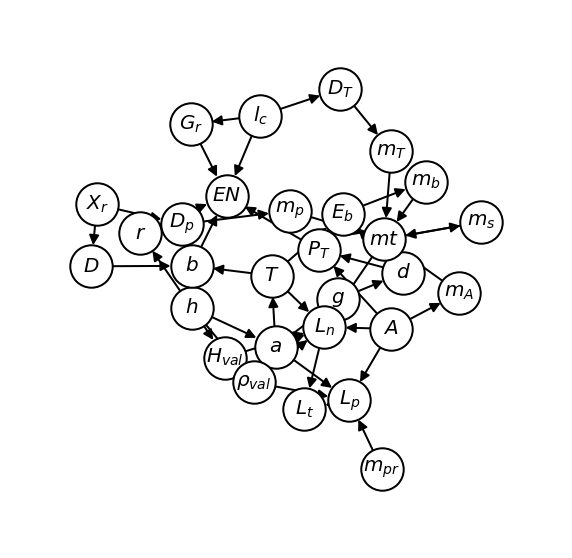

In [66]:
fig, ax = draw(DG, figsize=(10,10), node_shape='o', prog='fdp', node_size=1800)
#plt.sca(ax)
#plt.savefig('balloon', dpi=300, bbox_inches='tight')

In [41]:
edges = merge(alleqs, [eq0, eq1, eq2, eq3, eq4], 'orbit')
edges += merge(alleqs, [eq5, eq6, eq7, eq8, eq9], 'power')
edges += merge(alleqs, [eq10, eq11, eq12], 'payload')
edges += merge(alleqs, [eq13, eq14, eq15, eq16, eq16b, eq17], 'comms')
edges += merge(alleqs, [eq19], 'mass')
edges += merge(alleqs, [eq18], 'struct')
edges += merge(alleqs, [eq20, eq21, eq22, eq23, eq24], 'prop')

In [42]:
DGsys = nx.DiGraph(edges)

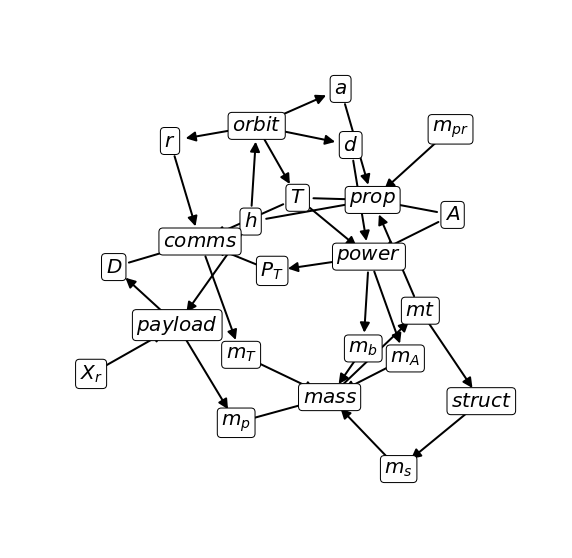

In [76]:
fig,ax = draw(DGsys, figsize=(10,10), node_shape='b', prog='neato', node_size=1000);
plt.sca(ax)
plt.savefig('toysat_graph.png', dpi=600)

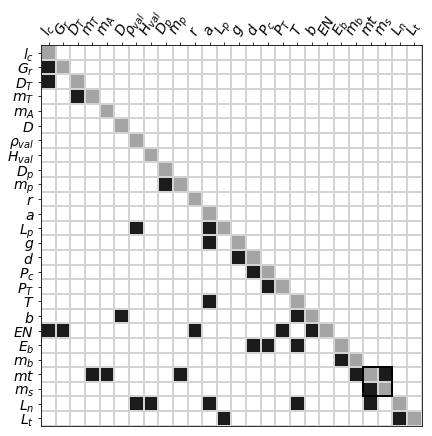

In [36]:
order = mdf_order(eqv, dout)
plt.figure(figsize=(7,7))
ax = draw_dsm(DG, flatten_order(order), dout)
rect2 = patches.Rectangle((22, 22), 2, 2, linewidth=2, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect2);
plt.savefig('toysat.png', dpi=600)

In [58]:
discp = {'orbit', 'power', 'payload', 'comms', 'mass', 'prop', 'struct'}

In [60]:
varnames = set(DGsys.nodes())-discp;

In [62]:
out = nx.strongly_connected_components(DGsys)

In [59]:
list(out)

[{'prop'},
 {m_s, 'mass', mt, 'struct'},
 {m_T},
 {'comms'},
 {r},
 {P_T},
 {m_A},
 {m_b},
 {'power'},
 {d},
 {a},
 {T},
 {'orbit'},
 {m_p},
 {D},
 {'payload'},
 {h},
 {A},
 {P_l},
 {rho_b},
 {X_r},
 {l_v},
 {rho_p},
 {T_s},
 {D_r},
 {eta},
 {G_T},
 {f},
 {L},
 {rho_T},
 {eta_S},
 {m_pr},
 {Isp},
 {C_D}]

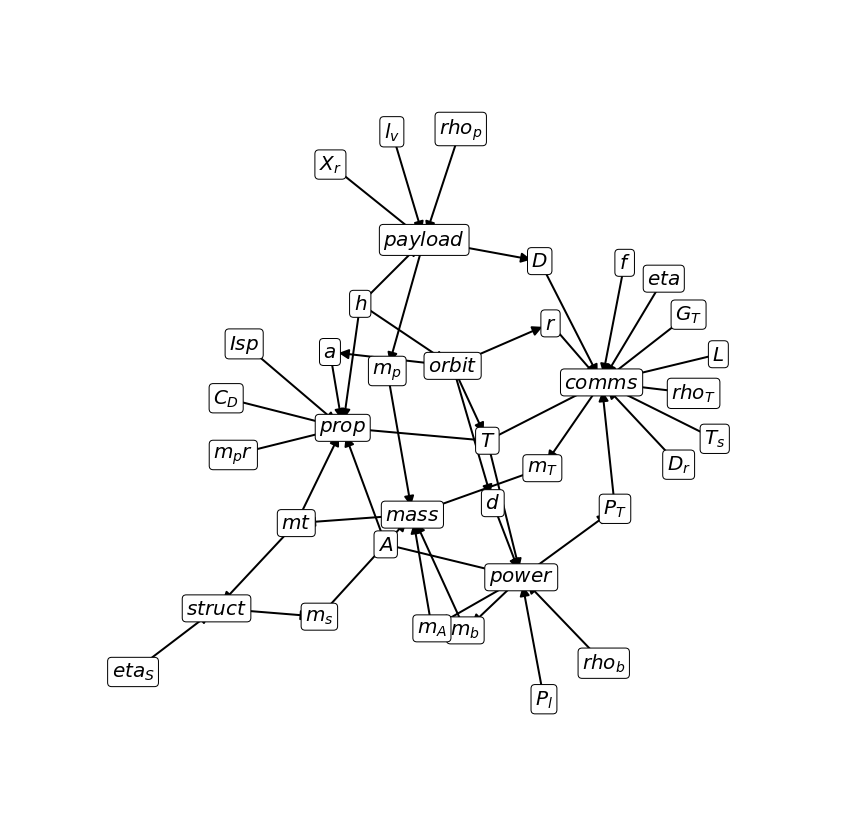

In [86]:
edge_color='k'
width=2
arc=False
figsize=(15,15)
labels = OrderedDict([(elt,r'${}$'.format(str(elt))) for elt in DG.nodes])
pos = nx.drawing.nx_pydot.graphviz_layout(DG, prog='neato')
plt.figure(figsize=figsize)
plt.margins(0.15)
nx.draw_networkx_nodes(DG, pos=pos, node_size=1000, node_shape="s",  node_color="none")
#https://stackoverflow.com/questions/22785849/drawing-multiple-edges-between-two-nodes-with-networkx
connectionstyle = 'arc3, rad = 0.1' if arc else None
nx.draw_networkx_edges(DG, pos=pos, arrowsize=20, width=width, 
    edge_color=edge_color, connectionstyle=connectionstyle)
nx.draw_networkx_labels(DG, pos, labels, font_size=20, bbox=dict(facecolor="white", edgecolor='black', boxstyle='round,pad=0.2'))
#nx.draw_networkx_labels(DG, pos, labels, font_size=20, bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'))
plt.gca().axis("off");

In [19]:
{elt for elt in dins if not elt.never_output}

{A, D_r, G_T, L, P_l, X_r, eta, eta_S, f, h, m_pr, rho_T, rho_p}

In [20]:
force_input = [EN, Lt]
not_input = [A, m_pr, X_r] #allow to vary, meaning can only be output

In [21]:
new_ins = dins.union(force_input) - set(not_input)
#new_ins = force_input
new_eqv = {key: {elt for elt in outsetposs if not elt in new_ins}
        for key, outsetposs in eqv.items()}

In [210]:
{elt for elt in new_ins if not elt.never_output}

{D_r, EN, G_T, L, Lt, P_l, eta, eta_S, f, h, rho_T, rho_p}

In [211]:
new_eqv

{0: {a},
 1: {T, a},
 2: {a, g},
 3: {d, g},
 4: {r},
 5: {A, m_A},
 6: {A, P_T, d},
 7: {P_T},
 8: {E_b, P_T, T, d},
 9: {E_b, m_b},
 10: {D_p, X_r},
 11: {D, X_r},
 12: {D_p, m_p},
 13: {D, T, b},
 14: {l_c},
 15: {D_T, l_c},
 16: {G_r, l_c},
 17: {D_T, m_T},
 18: {G_r, P_T, b, l_c, r},
 19: {m_s, mt},
 20: {m_A, m_T, m_b, m_p, m_s, mt},
 21: {Hval},
 22: {rhoval},
 23: {A, Hval, Ln, T, a, mt, rhoval},
 24: {A, Lp, a, m_pr, rhoval},
 25: {Ln, Lp}}

In [212]:
G, edges_original = bipartite_repr(new_eqv)

In [213]:
M = nx.bipartite.maximum_matching(G)

In [214]:
allvars = reduce(lambda a,b: a.union(b), new_eqv.values())

In [215]:
#resolve(new_eqv.keys(), allvars, invert_edges(edges_original))

In [216]:
d = {key:M[key] for key in dout.keys()}

In [221]:
eqs

{0: (a, R + h),
 1: (T, 6.28318530717959*(a**3/mu)**0.5),
 2: (g, 0.318309886183791*acos(R/a)),
 3: (d, g + 0.5),
 4: (r, (2*R*h + h**2)**0.5),
 5: (m_A, A*eta_A),
 6: (P_T, A*Q*d*eta_A),
 7: (P_T, P_l),
 8: (E_b, P_T*T/d),
 9: (m_b, E_b*rho_b),
 10: (D_p, 1.22*h*l_v/X_r),
 11: (D, 6.28318530717959*B*N*R/X_r),
 12: (m_p, D_p**1.5*rho_p),
 13: (b, D/T),
 14: (l_c, c/f),
 15: (D_T, 0.318309886183791*l_c*(G_T/eta)**0.5),
 16: (G_r, 9.86960440108936*D_r**2*eta/l_c**2),
 17: (m_T, D_T**1.5*rho_T),
 18: (EN, 0.00633257397764611*G_T*G_r*P_T*l_c**2/(L*T_s*b*k*r**2)),
 19: (m_s, eta_S*mt),
 20: (mt, m_A + m_T + m_b + m_p + m_s),
 21: (Hval, H(1000.0*h)),
 22: (rhoval, rho(1000.0*h)),
 23: (Ln, 0.159154943091895*Hval*T*mt/(A*C_D*a**2*rhoval)),
 24: (Lp, 2.0*G*Isp*a*m_pr/(A*C_D*mu*rhoval)),
 25: (Lt, Ln + Lp)}

In [217]:
new_eqs=reassign(eqs, d)
new_eqv = eqvars(new_eqs)
new_order = mdf_order(new_eqv, d)
new_ins = reduce(set.union, new_eqv.values()) - set(d.values())

In [218]:
new_order

[14,
 16,
 15,
 17,
 7,
 22,
 21,
 4,
 18,
 0,
 2,
 3,
 6,
 5,
 1,
 13,
 11,
 10,
 12,
 8,
 9,
 (19, 20),
 23,
 25,
 24]

In [20]:
order = mdf_order(eqv, dout)

In [21]:
#fx(*convert*np.array([c.varval, f.varval]).flatten())/factor

In [24]:
#convert, factor

In [29]:
expr = eqs[14][1]
input_names = list(expr.free_symbols)
fx = sp.lambdify(input_names, expr)
evaluable_with_unit(expr, input_names, tovar=eqs[14][0].varunit)(fx)(c.varval, f.varval)

13.59090909090909

In [28]:
input_names

[c, f]

In [32]:
Evaluable.fromsympy(eqs[14][1], eqs[14][0]).fx(c.varval, f.varval)

13.59090909090909

In [34]:
prob = om.Problem()
model = prob.model
dins = default_in(eqs)
buildidpvars(dins, model)
counter = coupled_run(eqs, order, (), model, model, debug=True)
prob.setup()
prob.set_solver_print(level=0)
prob.set_val('A', 0.1)
prob.set_val('h', 400)
prob.set_val('m_pr', 0.5)
prob.run_model()

eq14 l_c c/f None
eq16 G_r 9.86960440108936*D_r**2*eta/l_c**2 None
eq15 D_T 0.318309886183791*l_c*(G_T/eta)**0.5 None
eq17 m_T D_T**1.5*rho_T None
eq5 m_A A*rho_A None
eq22 rho_val rho(1000.0*h) None
eq21 H_val H(1000.0*h) None
eq10 D_p 1.22*h*l_v/X_r None
eq12 m_p D_p**1.5*rho_p None
eq11 D 6.28318530717959*B*N*R/X_r None
eq4 r (2*R*h + h**2)**0.5 None
eq0 a R + h None
eq24 L_p 2.0*G*Isp*a*m_pr/(A*C_D*mu*rho_val) None
eq2 g 0.318309886183791*acos(R/a) None
eq3 d g + 0.5 None
eq7 P_T P_l None
eq1 T 6.28318530717959*(a**3/mu)**0.5 None
eq13 b D/T None
eq18 EN 0.00633257397764611*G_T*G_r*P_T*l_c**2/(L*T_s*b*k*r**2) None
eq8 E_b P_T*T/d None
eq9 m_b E_b*rho_b None
eq19 m_s eta_S*mt None
eq20 mt m_A + m_T + m_b + m_p + m_s None
eq23 L_n 0.159154943091895*H_val*T*mt/(A*C_D*a**2*rho_val) None
eq25 L_t L_n + L_p None
l_c [13.59090909]
G_r [8255.00154877]
D_T [0.38986773]
m_T [0.04868621]
m_A [1.]
rho_val [2.72e-12]
H_val [58200.]
D_p [0.0488]
m_p [0.02156054]
D [16029.66235568]
r [2293992.153

In [39]:
out = get_outputs(eqs, model)

In [35]:
model.list_outputs();

53 Explicit Output(s) in 'model'

varname      val               
-----------  ------------------
inp
  R          [6378.]           
  Isp        [70.]             
  P_l        [5.]              
  c          [2.99e+08]        
  k          [1.38064852e-23]  
  L          [9.77]            
  T_s        [135.]            
  rho_A      [10.]             
  C_D        [2.2]             
  eta_A      [0.3]             
  D_r        [5.3]             
  f          [2.2]             
  B          [8.]              
  X_r        [5.]              
  h          [400.]            
  m_pr       [0.5]             
  G          [9.81]            
  eta_S      [0.2]             
  l_v        [500.]            
  Q          [1367.]           
  N          [2000.]           
  G_T        [44.66835922]     
  A          [0.1]             
  eta        [0.55]            
  mu         [3.986005e+14]    
  rho_b      [0.002]           
  rho_T      [0.2]             
  rho_p      [2.]              
gr

In [161]:
new_order

[14,
 16,
 15,
 17,
 7,
 11,
 (13, 1, 0, 4, 18),
 22,
 21,
 10,
 12,
 2,
 3,
 8,
 9,
 6,
 5,
 (19, 20),
 23,
 25,
 24]

In [168]:
allvars = reduce(lambda a,b: a.union(b), new_eqv.values())

In [169]:
G, edges_original = bipartite_repr(new_eqv)

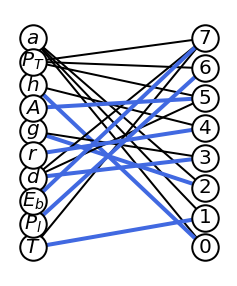

In [170]:
drawbipartite(G, left_nodes=allvars, M=M)

In [171]:
M = nx.bipartite.maximum_matching(G)

In [172]:
dout_new = {key:M[key] for key in dout.keys()}

In [173]:
new_eqs=reassign(eqs, dout_new)
new_eqv = eqvars(new_eqs)

In [181]:
G, edges = digraph_repr(new_eqv, dout_new, intermediary=True)

In [129]:
order

[6, 2, 3, 5, 1, 7, 0, 4]

In [ ]:
g1 = lambda d, A, η_A, P_T: d*A*η_A*Q-P_T-P_l # positive
g2 = lambda E_b, d, T, P_T: E_b-1/d*P_T*T
def g3(T, P_T, G_T, r):
    D = 2*np.pi*R*B*N/X_r
    b = D/T
    #print(b/(8*1e6)) #Mb/s
    #D_T = λ_c*np.sqrt(G_T/η)/np.pi
    λ_c = c/f
    G_r = η*(np.pi*D_r/λ_c)**2
    #print(G_r, P_T, G_T)
    EN_calc = P_T*G_r*G_T/(L*k*T_s*b)*(λ_c/(4*np.pi*r))**2
    #print(EN_calc)
    #print(10*np.log10(EN_calc)-10*np.log10(EN))
    return 10*np.log10(EN_calc)-10*np.log10(EN)
def f4(a, T, A, ρ_A, m_s, m_T, m_p, m_b, m_pr, choice):
    T_g = 3*μ/(2*a**3)*c_W
    if choice:
        m_torque = ρ_P2*T*T_g*1/4*np.sqrt(2)/2*3*365*L_min/(G*I_sp)
    else:
        m_torque = ρ_M*T_g
    m_A=ρ_A*A
    #print(m_s, m_T, m_p, m_b, m_pr, m_A, m_torque)
    return m_s+m_T+m_c+m_A+m_p+m_b+m_torque+m_pr
def g4(h, a, A, T, mt, m_pr):
    Ln = H(h)*mt/(2*np.pi*C_D*A*ρ(h)*a**2)*T
    #Ln2 = H(h)*3./(2*np.pi*C_D*.06603*ρ(h)*a**2)*T
    #print('density', ρ(h))
    #print('scale height', H(h))
    #print('prop mass', m_pr)
    #print('area', A)
    #print('mt', mt)
    Lp = m_pr*I_sp*G*a/(0.5*C_D*A*ρ(h)*μ)
    #Lp2 = 1.3911*I_sp*G*a/(0.5*C_D*.06603*ρ(h)*μ)
    #print(Ln*toyear, Lp*toyear)
    #print(Ln2*toyear, Lp2*toyear)
    return (Ln+Lp)*toyear-L_min
h5 = lambda ms, mt: ms - η_S*mt